### The goal is to predict whether a credit card client will default or not, based on their demographic and payment history.

The dataset is from https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from scipy.stats import lognorm, loguniform, randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("data/Credit_Card.csv")

In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(21000, 25)

In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 16395 to 19966
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          21000 non-null  int64  
 1   LIMIT_BAL                   21000 non-null  float64
 2   SEX                         21000 non-null  int64  
 3   EDUCATION                   21000 non-null  int64  
 4   MARRIAGE                    21000 non-null  int64  
 5   AGE                         21000 non-null  int64  
 6   PAY_0                       21000 non-null  int64  
 7   PAY_2                       21000 non-null  int64  
 8   PAY_3                       21000 non-null  int64  
 9   PAY_4                       21000 non-null  int64  
 10  PAY_5                       21000 non-null  int64  
 11  PAY_6                       21000 non-null  int64  
 12  BILL_AMT1                   21000 non-null  float64
 13  BILL_AMT2                  

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,14962.348238,167880.651429,1.600762,1.852143,1.554000,35.500810,-0.015429,-0.137095,-0.171619,-0.225238,...,43486.610905,40428.518333,38767.202667,5673.585143,5.895027e+03,5311.432286,4774.021381,4751.850095,5237.762190,0.223238
std,8650.734050,130202.682167,0.489753,0.792961,0.521675,9.212644,1.120465,1.194506,1.196123,1.168556,...,64843.303993,61187.200817,59587.689549,17033.241454,2.180143e+04,18377.997079,15434.136142,15228.193125,18116.846563,0.416427
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-50616.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7498.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2293.750000,1739.500000,1215.750000,1000.000000,8.200000e+02,390.000000,266.000000,234.000000,110.750000,0.000000
50%,14960.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19102.500000,18083.000000,16854.500000,2100.000000,2.007000e+03,1809.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22458.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54763.250000,50491.000000,49253.750000,5007.250000,5.000000e+03,4628.500000,4021.250000,4016.000000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
train_df.corr().style.background_gradient()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,1.000000,0.028419,0.019014,0.040633,-0.024071,0.021795,-0.029574,-0.011899,-0.017471,-0.000293,-0.022719,-0.022829,0.020447,0.019669,0.028270,0.042005,0.020323,0.019477,0.013488,0.013389,0.036544,0.010153,-0.000093,0.001252,-0.017861
LIMIT_BAL,0.028419,1.000000,0.027466,-0.223207,-0.115202,0.146419,-0.271686,-0.299924,-0.289222,-0.269399,-0.249030,-0.236218,0.283635,0.277334,0.283969,0.297468,0.299353,0.293757,0.191669,0.183705,0.206416,0.204308,0.215244,0.215337,-0.149247
SEX,0.019014,0.027466,1.000000,0.012307,-0.033413,-0.091890,-0.061038,-0.073214,-0.068192,-0.063772,-0.055062,-0.041594,-0.035212,-0.031960,-0.023333,-0.022471,-0.015973,-0.015158,0.001324,0.000908,-0.008136,0.001473,-0.004470,-0.001600,-0.046320
EDUCATION,0.040633,-0.223207,0.012307,1.000000,-0.142499,0.175042,0.111222,0.125907,0.118096,0.110732,0.101603,0.088186,0.026108,0.020668,0.016967,0.003286,-0.005203,-0.005595,-0.039769,-0.028295,-0.039621,-0.038918,-0.031589,-0.038563,0.026558
MARRIAGE,-0.024071,-0.115202,-0.033413,-0.142499,1.000000,-0.414446,0.016416,0.023994,0.035001,0.031905,0.035830,0.029353,-0.027264,-0.024688,-0.029866,-0.028532,-0.031878,-0.027376,-0.001337,-0.005287,-0.002401,-0.014206,-0.000819,-0.007532,-0.021735
AGE,0.021795,0.146419,-0.091890,0.175042,-0.414446,1.000000,-0.032232,-0.045343,-0.050597,-0.047465,-0.050073,-0.041689,0.064703,0.061367,0.062484,0.061071,0.059023,0.058003,0.023255,0.023572,0.034136,0.025197,0.028544,0.017527,0.010715
PAY_0,-0.029574,-0.271686,-0.061038,0.111222,0.016416,-0.032232,1.000000,0.670967,0.571947,0.534071,0.504219,0.470939,0.186433,0.187401,0.179065,0.172808,0.175548,0.173661,-0.076790,-0.071744,-0.074217,-0.065880,-0.053086,-0.063282,0.325102
PAY_2,-0.011899,-0.299924,-0.073214,0.125907,0.023994,-0.045343,0.670967,1.000000,0.770190,0.664641,0.622672,0.575450,0.235992,0.236222,0.226122,0.218033,0.216657,0.216919,-0.076280,-0.057781,-0.055477,-0.052057,-0.033231,-0.039994,0.265160
PAY_3,-0.017471,-0.289222,-0.068192,0.118096,0.035001,-0.050597,0.571947,0.770190,1.000000,0.779639,0.685032,0.631932,0.207658,0.235810,0.227556,0.221998,0.219870,0.218656,0.002073,-0.068541,-0.054288,-0.052475,-0.035079,-0.043431,0.240503
PAY_4,-0.000293,-0.269399,-0.063772,0.110732,0.031905,-0.047465,0.534071,0.664641,0.779639,1.000000,0.817452,0.713851,0.201714,0.224515,0.245064,0.240648,0.236905,0.234309,-0.005518,0.000193,-0.069715,-0.048923,-0.032754,-0.028226,0.219692


In [6]:
train_df["default.payment.next.month"].value_counts(normalize=True)

0    0.776762
1    0.223238
Name: default.payment.next.month, dtype: float64

In [7]:
custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer
train_df.max()

ID                              30000.0
LIMIT_BAL                     1000000.0
SEX                                 2.0
EDUCATION                           6.0
MARRIAGE                            3.0
AGE                                79.0
PAY_0                               8.0
PAY_2                               8.0
PAY_3                               8.0
PAY_4                               8.0
PAY_5                               8.0
PAY_6                               8.0
BILL_AMT1                      964511.0
BILL_AMT2                      983931.0
BILL_AMT3                      855086.0
BILL_AMT4                      891586.0
BILL_AMT5                      927171.0
BILL_AMT6                      961664.0
PAY_AMT1                       873552.0
PAY_AMT2                      1227082.0
PAY_AMT3                       896040.0
PAY_AMT4                       621000.0
PAY_AMT5                       426529.0
PAY_AMT6                       528666.0
default.payment.next.month          1.0


In [8]:
X_train, y_train = (
    train_df.drop(columns=["default.payment.next.month"]),
    train_df["default.payment.next.month"],
)
X_test, y_test = (
    test_df.drop(columns=["default.payment.next.month"]),
    test_df["default.payment.next.month"],
)

In [9]:
drop_features = ["ID"]

target = "default.payment.next.month"

numeric_features =[
 'LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

categorical_features =[
 'EDUCATION',
 'MARRIAGE']

binary_features = ['SEX']

In [10]:

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
)

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

In [12]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.001 (+/- 0.000)
score_time,0.002 (+/- 0.002)
test_score,0.505 (+/- 0.005)
train_score,0.500 (+/- 0.004)


In [13]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio

3.4795221843003414

In [14]:
models = {
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=2),
    "lgbm": LGBMClassifier(scale_pos_weight=ratio, random_state=2),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.002 (+/- 0.002),0.505 (+/- 0.005),0.500 (+/- 0.004)
random forest,2.346 (+/- 0.022),0.060 (+/- 0.001),0.671 (+/- 0.004),0.999 (+/- 0.000)
xgboost,0.883 (+/- 0.021),0.006 (+/- 0.000),0.680 (+/- 0.006),0.867 (+/- 0.003)
lgbm,0.322 (+/- 0.006),0.009 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004)


In [20]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)

In [21]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_...
                   param_distributions={'lgbmclassifier__learning_rate': [0.01,
                                                                          0.1],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1285c25f0>,
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11f6fd360>,
                                        'lgbmclassifier__subsample': [0.5, 0.75,
                                                                      1]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, average=macro), verbose=1)

In [22]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.002 (+/- 0.002),0.505 (+/- 0.005),0.500 (+/- 0.004)
random forest,2.346 (+/- 0.022),0.060 (+/- 0.001),0.671 (+/- 0.004),0.999 (+/- 0.000)
xgboost,0.883 (+/- 0.021),0.006 (+/- 0.000),0.680 (+/- 0.006),0.867 (+/- 0.003)
lgbm,0.322 (+/- 0.006),0.009 (+/- 0.000),0.691 (+/- 0.011),0.772 (+/- 0.004)
lgbm (tuned),0.070 (+/- 0.002),0.005 (+/- 0.000),0.708 (+/- 0.009),0.721 (+/- 0.003)


In [32]:
import shap

preprocessor.fit(X_train, y_train)

categorical_OHE = list(
    best_lgbm_model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names(categorical_features)
)

feature_names = numeric_features + binary_features + categorical_OHE 

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
16395,1.168355,0.054187,-0.300665,-0.293394,-0.265310,-0.371930,-0.494781,-0.587035,-0.039546,-0.040229,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21448,2.090017,-0.597108,-0.685307,-0.679495,0.585444,1.970295,1.805461,1.327534,-0.297166,3.739796,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20034,-0.060527,0.922579,-0.696132,-0.688319,-0.681234,-0.670935,-0.661045,-0.650908,-0.333097,-0.270403,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25755,-0.367748,-0.597108,0.687456,0.752583,0.835581,0.918719,0.501203,0.144527,-0.115517,-0.018028,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1438,-0.905384,2.008070,-0.040230,-0.031399,-0.287429,-0.245237,-0.204599,-0.191104,-0.333097,-0.206185,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
lgbm_tuned = LGBMClassifier(
    scale_pos_weight=ratio,
    random_state=2,
    learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
    n_estimators=random_search_lgbm.best_params_["lgbmclassifier__n_estimators"],
    subsample=random_search_lgbm.best_params_["lgbmclassifier__subsample"],
)

lgbm_tuned.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_tuned)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [34]:
values = np.abs(lgbm_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
PAY_0,0.379010
LIMIT_BAL,0.129931
PAY_AMT2,0.093941
BILL_AMT1,0.086548
PAY_AMT3,0.059370
PAY_2,0.051485
PAY_3,0.050122
PAY_AMT1,0.044178
PAY_AMT4,0.043867
PAY_4,0.039639


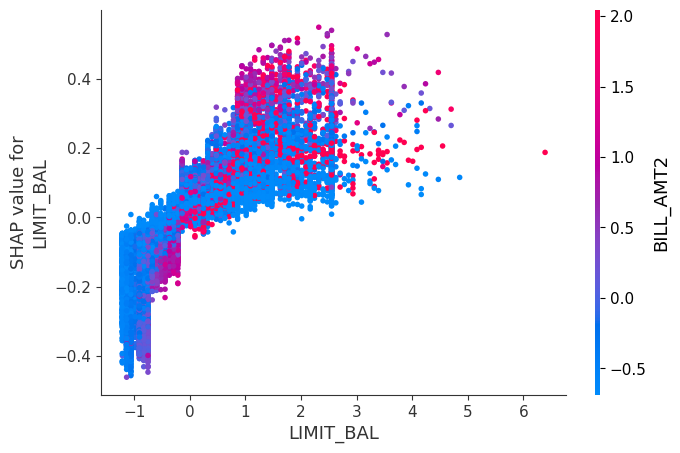

In [35]:
shap.dependence_plot("LIMIT_BAL", lgbm_shap_values[0], X_train_enc)

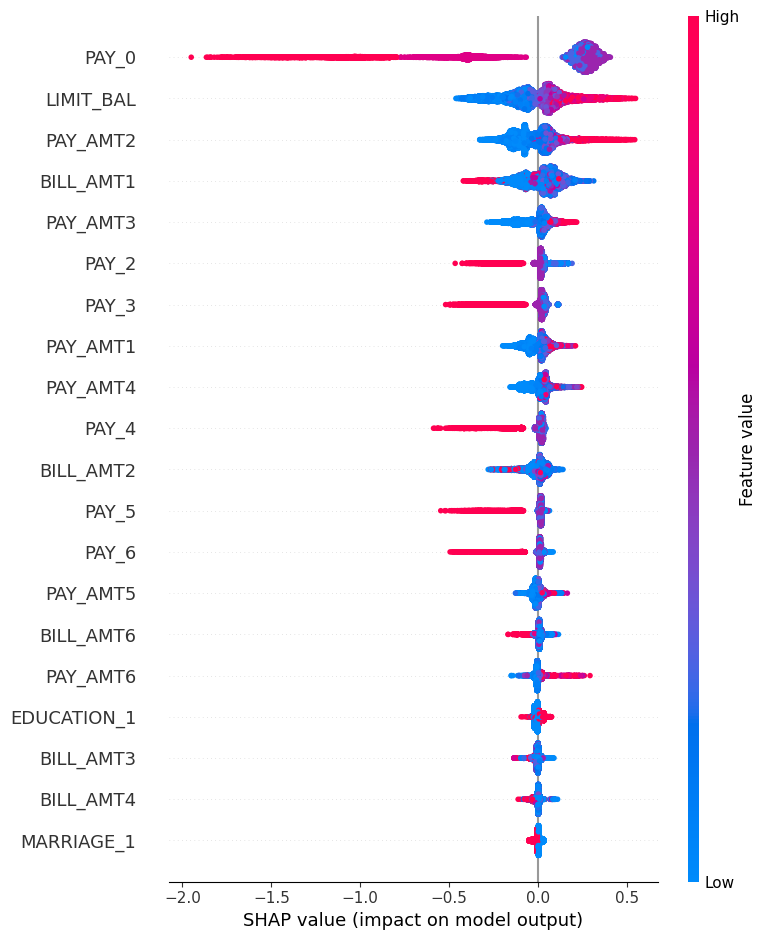

In [36]:
shap.summary_plot(lgbm_shap_values[0], X_train_enc)

In [37]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [38]:
lgbm_tuned.predict_proba(X_test_enc)[1]

array([0.74058038, 0.25941962])

In [39]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[1]

-1.0489872894312522

In [40]:
lgbm_explainer.expected_value

[0.5594117098974121, -0.5594117098974121]

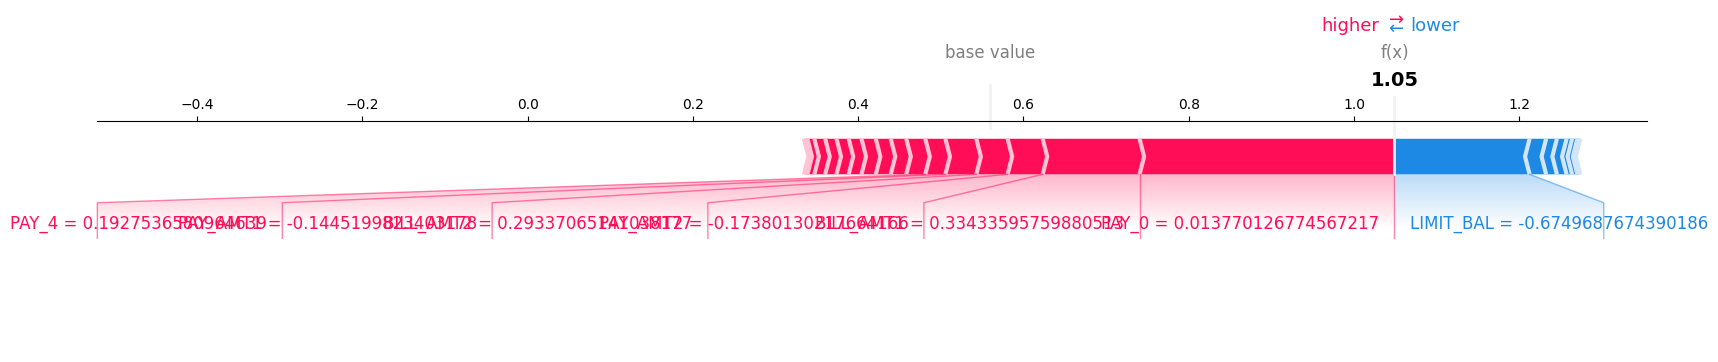

In [41]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][1, :],
    X_test_enc.iloc[1, :],
    matplotlib=True,
)

In [42]:
from sklearn.metrics import f1_score

best_model = random_search_lgbm.best_estimator_
print(
    "Grid Search best model validation score: %0.3f" % (random_search_lgbm.best_score_)
)

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Grid Search best model validation score: 0.708
Macro-average f1 score on the test set: 0.697


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


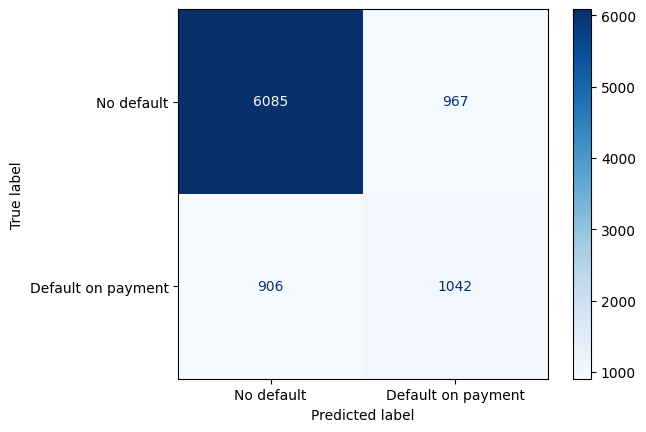

In [43]:
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(
    best_model,
    X_test,
    y_test,
    display_labels=["No default", "Default on payment"],
    values_format="d",
    cmap=plt.cm.Blues,
)

In [44]:
print(
    classification_report(
        y_test, predictions, target_names=["No default", "Default on payment"]
    )
)

                    precision    recall  f1-score   support

        No default       0.87      0.86      0.87      7052
Default on payment       0.52      0.53      0.53      1948

          accuracy                           0.79      9000
         macro avg       0.69      0.70      0.70      9000
      weighted avg       0.79      0.79      0.79      9000



In [45]:
y_test_reset = y_test.reset_index(drop=True)
non_default_ind = y_test_reset[y_test_reset == 0].index.tolist()
default_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_non_default_index = non_default_ind[0]
ex_default_index = default_ind[0]

In [46]:
lgbm_tuned.predict_proba(X_test_enc)[ex_non_default_index]

array([0.697763, 0.302237])

In [47]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_non_default_index]

-0.8366680315908269

In [48]:
lgbm_explainer.expected_value

[0.5594117098974121, -0.5594117098974121]

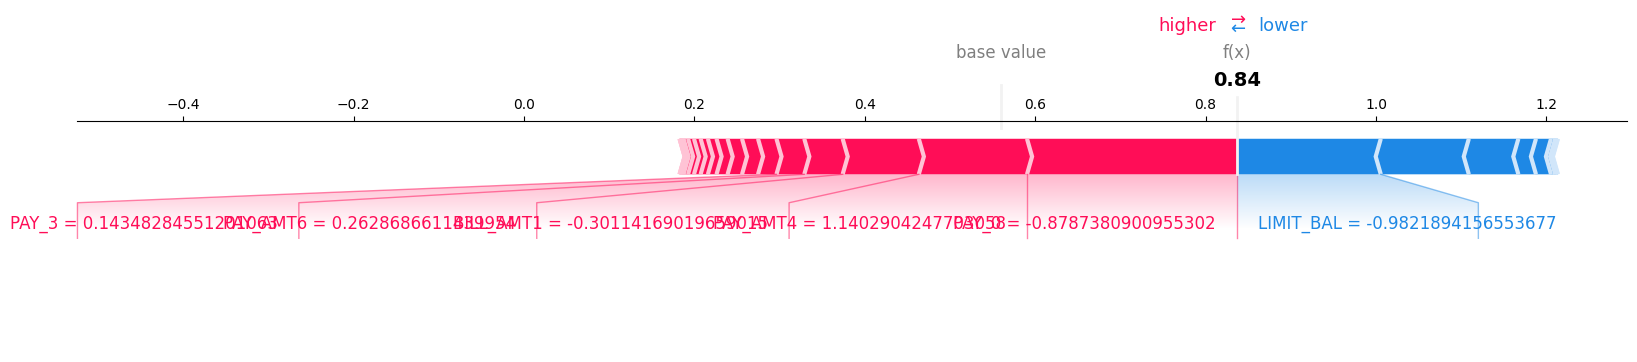

In [49]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][ex_non_default_index, :],
    X_test_enc.iloc[ex_non_default_index, :],
    matplotlib=True,
)

**Explanation of a default prediction**

In [51]:
lgbm_tuned.predict_proba(X_test_enc)[ex_default_index]

array([0.26909715, 0.73090285])

In [52]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_default_index]

0.9992080664830868

In [53]:
lgbm_explainer.expected_value

[0.5594117098974121, -0.5594117098974121]

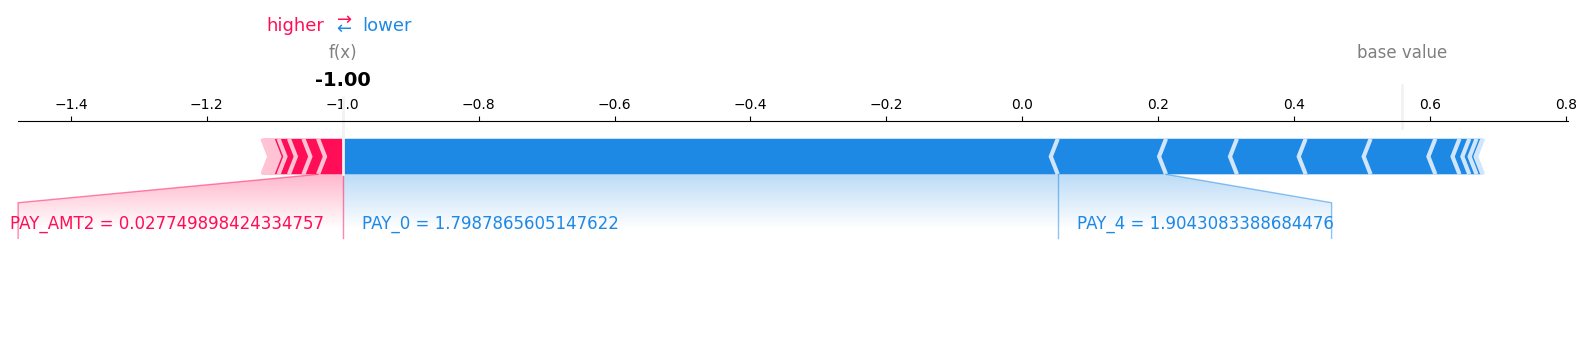

In [54]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][ex_default_index, :],
    X_test_enc.iloc[ex_default_index, :],
    matplotlib=True,
)